<a href="https://colab.research.google.com/github/NeetaTaneja/GL/blob/master/R9_Internal_Lab_on_ACV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os

### Change directory

In [3]:
os.chdir("/content/gdrive/MyDrive/AIML/LabML-R9/Internal")

In [4]:
os.listdir()

['Questions - Lab on ACV.ipynb',
 'train_labels.csv',
 'Dataset-Images_racoon.rar',
 'images',
 'finalmodel.h5',
 'model.h5']

In [5]:
!pip install rarfile

In [6]:
from rarfile import RarFile

with RarFile("Dataset-Images_racoon.rar","r") as z:
  z.extractall()

### Load the training data from train.csv file

In [7]:
data= pd.read_csv('./train_labels.csv',encoding = 'unicode_escape')

In [8]:
data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [9]:
data.shape

(173, 8)

In [10]:
data['class'].nunique()

1

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [11]:
IMAGE_SIZE=128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [12]:
paths = []
coords = np.zeros((data.shape[0],4))

for index,row in data.iterrows():
  path = "./images/" + row["filename"]
  
  #1. Append relative path to the list of paths
  paths.append(path)

  #Standardize the coordinates according to 128X128 image size
  coords[index, 0] = row['xmin'] * IMAGE_SIZE / row['width']
  coords[index, 1] = row['ymin'] * IMAGE_SIZE / row['height']
  coords[index, 2] = row['xmax'] * IMAGE_SIZE / row['width']
  coords[index, 3] = row['ymax'] * IMAGE_SIZE / row['height']

In [13]:
paths[0:10]

['./images/raccoon-17.jpg',
 './images/raccoon-11.jpg',
 './images/raccoon-63.jpg',
 './images/raccoon-63.jpg',
 './images/raccoon-60.jpg',
 './images/raccoon-69.jpg',
 './images/raccoon-180.jpg',
 './images/raccoon-200.jpg',
 './images/raccoon-141.jpg',
 './images/raccoon-19.jpg']

In [14]:
num_images = len(paths)
print("Number of images = ",num_images)

Number of images =  173


### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [15]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

In [16]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE,3))

for i, image in enumerate(paths):
  #1 Read the image
  img = Image.open(image)
  # Resize the image to 128*128
  img = img.resize((IMAGE_SIZE,IMAGE_SIZE))
  #Convert to RGB
  img = img.convert('RGB')

  batch_images[i] = preprocess_input(np.array(img,dtype = np.float32))

In [17]:
len(batch_images)

173

In [18]:
batch_images.shape

(173, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


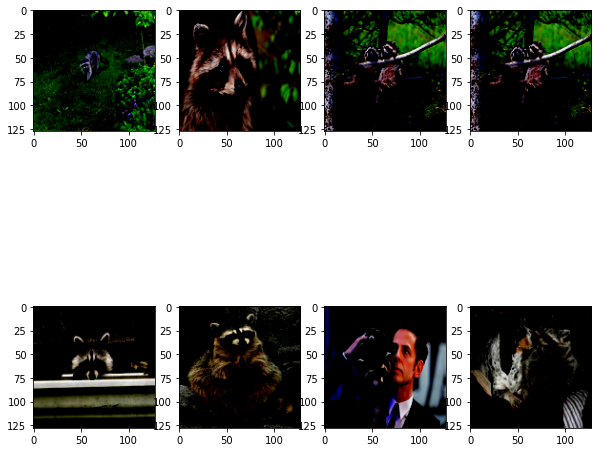

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))

for i in range(1, 9):
    img = batch_images[i-1]
    fig.add_subplot(2, 4, i)
    plt.imshow(img)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [20]:
# Import packages for mobileNet
import tensorflow as tf

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.backend import epsilon

from tensorflow.keras.applications.mobilenet import MobileNet

In [21]:
tf.keras.backend.clear_session()
num_classes = 4

#Initialize model, reshape & normalize data
model = MobileNet(include_top=False, #Do not include FC layer at the end
                  input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

#Set pre-trained model layers to not trainable
for layer in model.layers:
    layer.trainable = False

#get Output layer of Pretrained model
x = model.layers[-1].output

x = Conv2D(num_classes, kernel_size = 4, name = "coords")(x)
x = Reshape((4,))(x)
model = Model(inputs = model.input, outputs = x)

In [22]:
print (model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0     

### Define a custom loss function IoU which calculates Intersection Over Union

In [23]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [24]:
model.compile(loss="mse", metrics=[IoU], optimizer="adam")

In [25]:
# Use earlystopping
earlystopper = EarlyStopping(patience=5, min_delta=0.01, monitor= 'loss')
checkpointer = ModelCheckpoint(filepath='model.h5', 
                               verbose=1,save_best_only=True, monitor = 'loss')

In [26]:
# Fit the model
history = model.fit(batch_images, coords, batch_size=32, epochs=30,verbose = 1, 
                    callbacks = [checkpointer, earlystopper])

Epoch 1/30
6/6 [==============================] - 4s 417ms/step - loss: 4761.4395 - IoU: 0.0472

Epoch 00001: loss improved from inf to 3951.64673, saving model to model.h5
Epoch 2/30
6/6 [==============================] - 3s 414ms/step - loss: 990.7362 - IoU: 0.3679

Epoch 00002: loss improved from 3951.64673 to 748.52686, saving model to model.h5
Epoch 3/30
6/6 [==============================] - 3s 414ms/step - loss: 405.9292 - IoU: 0.5935

Epoch 00003: loss improved from 748.52686 to 471.62537, saving model to model.h5
Epoch 4/30
6/6 [==============================] - 3s 409ms/step - loss: 636.8124 - IoU: 0.5296

Epoch 00004: loss did not improve from 471.62537
Epoch 5/30
6/6 [==============================] - 2s 406ms/step - loss: 340.8146 - IoU: 0.6272

Epoch 00005: loss improved from 471.62537 to 317.91034, saving model to model.h5
Epoch 6/30
6/6 [==============================] - 3s 413ms/step - loss: 179.8643 - IoU: 0.6704

Epoch 00006: loss improved from 317.91034 to 188.90889

### Pick a test image from the given data

In [27]:
file_name = "./images/raccoon-28.jpg"
img = Image.open(file_name)
unscaled = img


### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


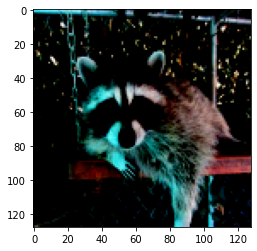

In [28]:
img = img.resize((IMAGE_SIZE,IMAGE_SIZE))
img = img.convert('RGB')
x_test = preprocess_input(np.array(img,dtype = np.float32))
print(x_test.shape)
plt.imshow(x_test)

### Predict the coordinates of the bounding box for the given test image

In [29]:
y_pred = model.predict(x_test.reshape(1,128,128,3))
print(y_pred)

[[ 14.185583  11.948587 102.15542  123.79683 ]]


### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [30]:
region = y_pred[0]

In [31]:
image_width = unscaled.size[0]
image_height = unscaled.size[1]
print(image_width, image_height)

602 452


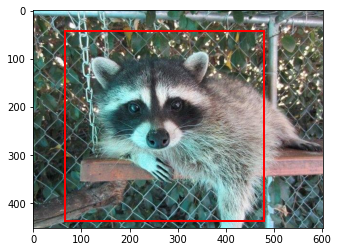

In [32]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()